#**Breast Tumor Segmentation**

In [1]:
import os
from google.colab import drive

path_proyecto = "ProyectoIA-H2"
path = "/content/drive/My Drive/" + path_proyecto

drive.mount('/content/drive/')
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/ProyectoIA-H2


In [2]:
from PIL import Image
from skimage.filters import roberts, sobel, scharr, prewitt
import cv2
import re
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
from scipy import ndimage as nd

In [3]:
PATH = "Dataset_BUSI_with_GT"

In [4]:
def collect_data(name):
    all_images = sorted(
        glob(os.path.join(PATH, name + "/*).png")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
    all_masks = sorted(
        glob(os.path.join(PATH, name + "/*mask*")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
    return all_images, all_masks

In [5]:
def group_maks(masks):
    new_masks = []
    retard = 0
    for i in range(len(masks)):
        m = re.search(r"mask_[0-9]", masks[i])
        if m:
            new_masks[i - (retard + 1)] += cv2.resize(cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256))
            retard += 1
        else:
            new_masks.append(cv2.resize(cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256)))
    return new_masks

In [6]:
all_benign_images, all_benign_masks = collect_data("benign")
all_benign_masks = group_maks(all_benign_masks)

all_malignant_images, all_malignant_masks = collect_data("malignant")
all_malignant_masks = group_maks(all_malignant_masks)

all_images = all_benign_images + all_malignant_images
all_masks = all_benign_masks + all_malignant_masks

In [7]:
images = []
for i in range(len(all_images)):
  images.append(cv2.resize(cv2.imread(all_images[i], cv2.IMREAD_GRAYSCALE), (256, 256)))

In [8]:
new_images = np.asarray(images)
all_masks = np.asarray(all_masks)
print(all_masks.shape)
print(new_images.shape)

(647, 256, 256)
(647, 256, 256)


In [9]:
X_train, X_test = train_test_split(new_images,test_size=0.2,random_state=1,shuffle = False)
y_train, y_test = train_test_split(all_masks,test_size=0.2,random_state=1,shuffle = False)

X_train, X_test = X_train/255, X_test/255
y_train, y_test = y_train/255, y_test/255

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [10]:
y_train = np.expand_dims(y_train, axis = 3) 

X_train = np.expand_dims(X_train, axis = 3)

#**Random Forest for image segmentation**

In [11]:
#X = X_train.reshape(-1)
selected_image = 25

img = new_images[selected_image]
img2 = img.reshape(-1)
df = pd.DataFrame()
df['Original Image'] = img2

In [12]:
num = 1
kernels = []
for theta in range(2):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for lamda in np.arange(0, np.pi, np.pi / 4):  
            for gamma in (0.05, 0.5):   
            
                
                gabor_label = 'Gabor' + str(num)

                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)

                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img 
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1 

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

In [13]:
edge = cv2.Canny(img, 100,200)
edge1 = edge.reshape(-1)  
df['Canny Edge'] = edge1

#Roberts Edge
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#Sobel Edge
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#Scharr Edge
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#Prewitt Edge
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#Gaussian con sigma 3
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#Gaussian con sigma 7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#Median con sigma 3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

In [14]:
label_img = y_train[selected_image]
label_img2 = label_img.reshape(-1)
df['Label'] = label_img2

df.head(10)

,Original Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor32,Canny Edge,Roberts,Sobel,Scharr,Prewitt,Gaussian s3,Gaussian s7,Median s3,Label
0,7,0,0,255,252,147,82,59,33,0,...,0,255,0.390684,0.342599,0.363071,0.317355,92,108,33,0.0
1,160,0,0,255,252,147,82,59,33,0,...,98,0,0.084882,0.274336,0.275812,0.288889,94,109,87,0.0
2,87,0,0,255,255,169,84,69,34,0,...,105,255,0.523974,0.356477,0.384628,0.328167,98,109,87,0.0
3,11,0,0,255,255,178,88,72,36,0,...,0,0,0.484413,0.093184,0.098072,0.095916,104,110,87,0.0
4,137,0,0,255,255,174,96,71,39,0,...,75,255,0.038623,0.340755,0.342982,0.337788,110,111,132,0.0
5,137,0,0,255,255,199,107,81,44,0,...,124,0,0.047708,0.031677,0.032902,0.030179,117,113,134,0.0
6,134,0,0,255,255,197,116,80,47,0,...,23,0,0.034745,0.028633,0.029319,0.027791,122,114,134,0.0
7,134,0,0,255,255,209,122,85,50,0,...,37,0,0.031617,0.026543,0.025264,0.028294,127,116,134,0.0
8,139,0,0,255,255,233,128,95,52,0,...,70,0,0.016169,0.027240,0.026146,0.028699,130,117,139,0.0
9,142,0,0,255,255,234,130,95,52,0,...,66,0,0.022356,0.026759,0.027465,0.026095,132,119,142,0.0


In [15]:
Y = df["Label"].values
X = df.drop(labels = ["Label"], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

y_train[y_train >= 0.5] = 1
y_train[y_train < 0.5] = 0

y_test[y_test >= 0.5] = 1
y_test[y_test < 0.5] = 0

In [16]:
#x = np.array(y_train)
#print(np.unique(x))

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

est = RandomForestClassifier(max_depth=10, n_estimators=150, random_state=21)
est.fit(X_train, y_train)

y_pred=est.predict(X_test)
acc = accuracy_score(y_pred,y_test)

report = classification_report(y_test,y_pred)

print(acc)
print(report)

0.9686057600610337
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     22744
         1.0       0.97      0.79      0.87      3471

    accuracy                           0.97     26215
   macro avg       0.97      0.89      0.93     26215
weighted avg       0.97      0.97      0.97     26215



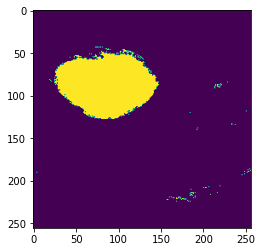

In [18]:
prediction = est.predict(X)
predicted_mask = prediction.reshape((img.shape))

ground_truth = np.reshape(Y, (256,256))

plt.imshow(predicted_mask)

# **SVC for image segmentation**

In [19]:
from sklearn.svm import LinearSVC

estSVC = LinearSVC(max_iter = 100)
estSVC.fit(X_train, y_train)

SVC_prediction = estSVC.predict(X)
SVC_mask = SVC_prediction.reshape((img.shape))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


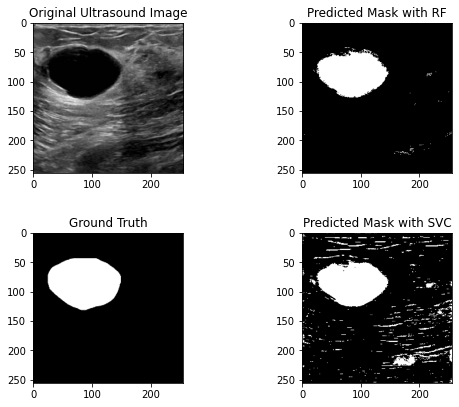

In [20]:
fig, axs = plt.subplots(2,2, figsize=(8,5))

Original_image = selected_image
axs[0,0].set(title = 'Original Ultrasound Image')
axs[0,0].imshow(img, cmap = 'gray')

axs[1,0].set(title = 'Ground Truth')
axs[1,0].imshow(ground_truth, cmap = plt.cm.gray)

axs[0,1].set(title = 'Predicted Mask with RF')
axs[0,1].imshow(predicted_mask, cmap = plt.cm.gray)

axs[1,1].set(title = 'Predicted Mask with SVC')
axs[1,1].imshow(SVC_mask, cmap = plt.cm.gray)

plt.subplots_adjust(left=0.2, bottom=0.2, right=1, top=1.2, wspace=0.4, hspace=0.4)
plt.show()

In [21]:
X_train_seg, X_test_seg = train_test_split(new_images,test_size=0.2,random_state=1,shuffle = False)
y_train_seg, y_test_seg = train_test_split(all_masks,test_size=0.2,random_state=1,shuffle = False)

X_train_seg, X_test_seg = X_train_seg/255, X_test_seg/255
y_train_seg, y_test_seg = y_train_seg/255, y_test_seg/255

X_train_seg = X_train_seg.astype(np.float32)
X_test_seg = X_test_seg.astype(np.float32)
y_train_seg = y_train_seg.astype(np.float32)
y_test_seg = y_test_seg.astype(np.float32)


#**Tumor segmentation with U-net**

In [27]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, concatenate, Conv2DTranspose

inputs = Input((256, 256, 1))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')

In [28]:
model.compile(optimizer = 'Adam',loss="binary_crossentropy",metrics=["accuracy"],)

In [29]:
model.fit(X_train_seg,y_train_seg, epochs = 50)

Epoch 1/50
17/17 [==============================] - 13s 395ms/step - loss: 0.3836 - accuracy: 0.8492
Epoch 2/50
17/17 [==============================] - 5s 297ms/step - loss: 0.2775 - accuracy: 0.9200
Epoch 3/50
17/17 [==============================] - 5s 298ms/step - loss: 0.2452 - accuracy: 0.9228
Epoch 4/50
17/17 [==============================] - 5s 297ms/step - loss: 0.2220 - accuracy: 0.9269
Epoch 5/50
17/17 [==============================] - 5s 297ms/step - loss: 0.2132 - accuracy: 0.9265
Epoch 6/50
17/17 [==============================] - 5s 295ms/step - loss: 0.2079 - accuracy: 0.9286
Epoch 7/50
17/17 [==============================] - 5s 294ms/step - loss: 0.1943 - accuracy: 0.9331
Epoch 8/50
17/17 [==============================] - 5s 293ms/step - loss: 0.2055 - accuracy: 0.9304
Epoch 9/50
17/17 [==============================] - 5s 292ms/step - loss: 0.2036 - accuracy: 0.9303
Epoch 10/50
17/17 [==============================] - 5s 292ms/step - loss: 0.1898 - accuracy: 0.933

In [32]:
predictions_Unet = model.predict(X_test_seg)

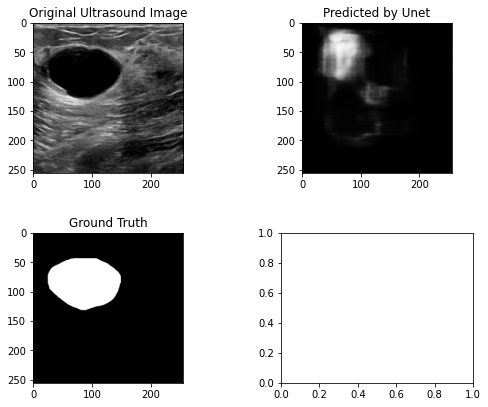

In [40]:
fig, axs = plt.subplots(2,2, figsize=(8,5))

Original_image = selected_image
axs[0,0].set(title = 'Original Ultrasound Image')
axs[0,0].imshow(img, cmap = 'gray')

axs[1,0].set(title = 'Ground Truth')
axs[1,0].imshow(ground_truth, cmap = plt.cm.gray)

axs[0,1].set(title = 'Predicted by Unet')
axs[0,1].imshow(np.squeeze(predictions_Unet[25]), cmap = plt.cm.gray)

plt.subplots_adjust(left=0.2, bottom=0.2, right=1, top=1.2, wspace=0.4, hspace=0.4)
plt.show()